In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import joblib
import os       
import sys
import warnings
warnings.filterwarnings("ignore")   
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


In [45]:
##############################################NEW SECTION OF CODE. - BALANCE THE CODE TO ENSURE ACCURACY  #####################################################

# Load dataset
df = pd.read_csv("/Users/anyakhurana/Documents/Rpo_analysis_project/rpoABC_variation_rifampicin_resistance.csv")

# Target encoding
y = df['Resistance'].map({'S': 0, 'R': 1}).astype(int)

# One-hot encode features
X = df.drop(columns=['ID', 'Resistance'])
X = pd.get_dummies(X, drop_first=False)

# Stratified CV for fairness
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Class balance:", y.value_counts(normalize=True))
print("X shape:", X.shape)

############################################## SAVE THE MODEL TO NEW PATH ###############################################################################################


## Prepares data for the ML Models
# Define the path to save the model
model_path = "/Users/anyakhurana/Documents/Rpo_analysis_project/rpoABC_variation_rifampicin_resistance_model.pkl"
# Check if the model already exists
if os.path.exists(model_path):
    print("Model already exists. Loading the model...")
    model = joblib.load(model_path)
else:  
    print("Model does not exist. Creating a new model...")
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Create a pipeline with scaling and classifier
    pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', XGBClassifier(random_state=42))
    ])
    
    # Fit the model
    pipeline.fit(X, y)
    
    # Save the model
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")



############################################## # fair and repeatable 10-fold cross-validation that preserves class balance,##############################################################################################

from sklearn.model_selection import StratifiedKFold
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)





############################################## # DEFINE THE SVM PIPELINE ##############################################################################################


xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),       # Optional: scale features
    ('clf', XGBClassifier(
        use_label_encoder=False,       # Avoid unnecessary warnings
        eval_metric='logloss',         # Standard for classification
        random_state=42
    ))
])


##############################################TRAIN AND TEST DATA##############################################################################################

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,     
    random_state=42
)
print("Training set class balance:", y_train.value_counts(normalize=True))
print("Test set class balance:", y_test.value_counts(normalize=True))


############################################## HYPERTUNE THE XG-BOOST##############################################################################################


xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_search.best_params_)





############################################## CROSS VALIDATING THE XG-BOOST##############################################################################################


from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import numpy as np

# If you have already done hyperparameter tuning for XGBoost:
best_params_xgb = {
    'n_estimators': 100,   # replace with your tuned values
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 1,
    'colsample_bytree': 1
}

# Create the best XGBoost classifier
xgb_best = XGBClassifier(
    **best_params_xgb,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 10-fold stratified cross-validation
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores_xgb = cross_val_score(xgb_best, X, y, cv=cv_10)

print("Cross-validation accuracies (XGBoost):", scores_xgb)
print("Average accuracy (XGBoost):", np.mean(scores_xgb))



############################################## FINAL GRAPH CLASS ##############################################################################################




Class balance: Resistance
1    0.5
0    0.5
Name: proportion, dtype: float64
X shape: (98, 197)
Model already exists. Loading the model...
Training set class balance: Resistance
0    0.5
1    0.5
Name: proportion, dtype: float64
Test set class balance: Resistance
1    0.5
0    0.5
Name: proportion, dtype: float64
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Cross-validation accuracies (XGBoost): [0.9        1.         1.         0.8        1.         0.8
 1.         1.         0.88888889 1.        ]
Average accuracy (XGBoost): 0.9388888888888889


In [ ]:

xgb_best.fit(X_train, y_train)


y_pred = xgb_best.predict(X_test)


from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)
print(report_df)


              precision  recall  f1-score  support
0                   1.0     1.0       1.0     10.0
1                   1.0     1.0       1.0     10.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     20.0
weighted avg        1.0     1.0       1.0     20.0


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd


y_pred = xgb_best.predict(X_test)

#get classification report
report = classification_report(y_test, y_pred, output_dict=True)


report_df = pd.DataFrame(report).transpose()


report_df = report_df.round(2)

print(report_df)


              precision  recall  f1-score  support
0                   1.0     1.0       1.0     10.0
1                   1.0     1.0       1.0     10.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     20.0
weighted avg        1.0     1.0       1.0     20.0


In [42]:
############################################# FINAL ACCURACY GRAPH FOR THE MODEL (XGBOOST) ##############################################################################################

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Features and target
X = df.drop(columns=['ID', 'Resistance'])
y = df['Resistance']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = xgb.XGBClassifier(
    n_estimators=200,       
    max_depth=6,            
    subsample=0.8,          
    colsample_bytree=0.8,   
    random_state=42,
    use_label_encoder=False, 
    eval_metric='mlogloss'   
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

############################################# CONFUSION MATRIX ##############################################################################################

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.show()


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['R' 'S']

In [39]:
############################################# FINAL ACCURACY GRAPH FOR THE MODEL (XGBOOST) #############################################

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Features and target
X = df.drop(columns=['ID', 'Resistance'])
y = df['Resistance']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# XGBoost model
model = xgb.XGBClassifier(
    n_estimators=200,       
    max_depth=6,            
    subsample=0.8,          
    colsample_bytree=0.8,   
    random_state=42,
    use_label_encoder=False, 
    eval_metric='mlogloss'   
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

############################################# CONFUSION MATRIX #############################################

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost Model")
plt.show()


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['R' 'S']

Accuracy: 1.0
              precision    recall  f1-score   support

           R       1.00      1.00      1.00        10
           S       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



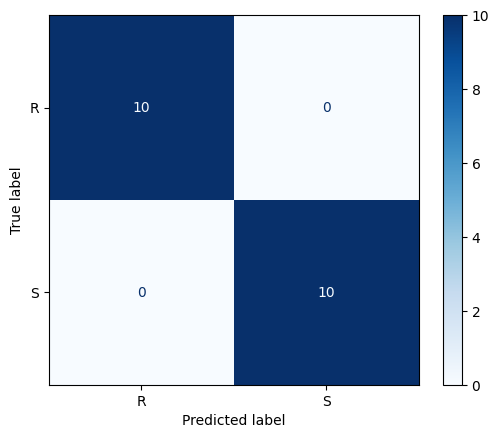

In [36]:
############################################# FINAL ACCURACY GRAPH FOR THE MODEL (XGBOOST) ##############################################################################################

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Features and target
X = df.drop(columns=['ID', 'Resistance'])
y = df['Resistance']

# Convert categorical features to numeric
X_encoded = pd.get_dummies(X)

# Encode labels ('R', 'S') -> (0,1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)   # R/S -> 0/1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define and train XGBoost model
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))  # <-- back to R/S

############################################# CONFUSION MATRIX ##############################################################################################

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.show()


In [32]:
print(report_df)

              precision  recall  f1-score  support
0                   1.0     1.0       1.0     10.0
1                   1.0     1.0       1.0     10.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     20.0
weighted avg        1.0     1.0       1.0     20.0


In [34]:
print(report)

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 20.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 20.0}}


In [40]:
############################################# FINAL ACCURACY GRAPH FOR THE MODEL (XGBOOST) #############################################

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Features and target
X = df.drop(columns=['ID', 'Resistance'])
y = df['Resistance']

# Encode labels ('R' -> 0, 'S' -> 1 automatically)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# XGBoost model
model = xgb.XGBClassifier(
    n_estimators=200,       
    max_depth=6,            
    subsample=0.8,          
    colsample_bytree=0.8,   
    random_state=42,
    use_label_encoder=False, 
    eval_metric='mlogloss'   
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy and classification report (decode back to 'R' and 'S')
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(le.inverse_transform(y_test), 
                            le.inverse_transform(y_pred)))

############################################# CONFUSION MATRIX #############################################

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost Model")
plt.show()


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:NC_000962.3:3877464-3878507+287: object, NC_000962.3:3877464-3878507+689: object, NC_000962.3:759807-763325+36: object, NC_000962.3:759807-763325+97: object, NC_000962.3:759807-763325+132: object, NC_000962.3:759807-763325+509: object, NC_000962.3:759807-763325+606: object, NC_000962.3:759807-763325+673: object, NC_000962.3:759807-763325+696: object, NC_000962.3:759807-763325+801: object, NC_000962.3:759807-763325+857: object, NC_000962.3:759807-763325+1133: object, NC_000962.3:759807-763325+1289: object, NC_000962.3:759807-763325+1303: object, NC_000962.3:759807-763325+1304: object, NC_000962.3:759807-763325+1325: object, NC_000962.3:759807-763325+1333: object, NC_000962.3:759807-763325+1334: object, NC_000962.3:759807-763325+1335: object, NC_000962.3:759807-763325+1349: object, NC_000962.3:759807-763325+1471: object, NC_000962.3:759807-763325+2014: object, NC_000962.3:759807-763325+2479: object, NC_000962.3:759807-763325+2728: object, NC_000962.3:759807-763325+3189: object, NC_000962.3:759807-763325+3225: object, NC_000962.3:763370-767320+321: object, NC_000962.3:763370-767320+1204: object, NC_000962.3:763370-767320+1297: object, NC_000962.3:763370-767320+1355: object, NC_000962.3:763370-767320+1380: object, NC_000962.3:763370-767320+1432: object, NC_000962.3:763370-767320+1448: object, NC_000962.3:763370-767320+1449: object, NC_000962.3:763370-767320+1451: object, NC_000962.3:763370-767320+1453: object, NC_000962.3:763370-767320+1471: object, NC_000962.3:763370-767320+1519: object, NC_000962.3:763370-767320+1549: object, NC_000962.3:763370-767320+1776: object, NC_000962.3:763370-767320+2093: object, NC_000962.3:763370-767320+2201: object, NC_000962.3:763370-767320+2249: object, NC_000962.3:763370-767320+2290: object, NC_000962.3:763370-767320+2498: object, NC_000962.3:763370-767320+2726: object, NC_000962.3:763370-767320+2843: object, NC_000962.3:763370-767320+2873: object, NC_000962.3:763370-767320+3116: object, NC_000962.3:763370-767320+3119: object, NC_000962.3:763370-767320+3525: object, NC_000962.3:763370-767320+3606: object, Sample: object